Resolution:  (512, 512)


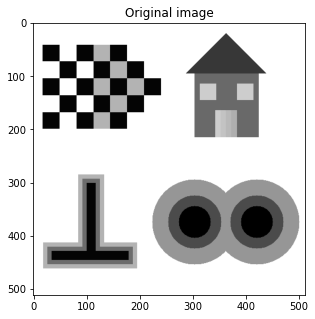

In [35]:
############### PART 1 ############### 
############### 1.1.1 ############### 
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import cv2

# read image in grayscale mode
path = '../data/edgetest_10.png'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
print("Resolution: ", img.shape) # Resolution:  (512, 512)

# Normalize to [0,1]
img = img.astype(np.float)/255

# Show image
plt.figure(figsize=(10,5))
plt.title('Original image')
plt.imshow(img, cmap='gray') # print image for check
plt.show()

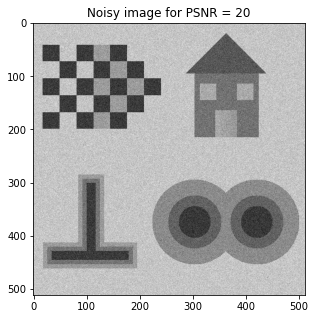

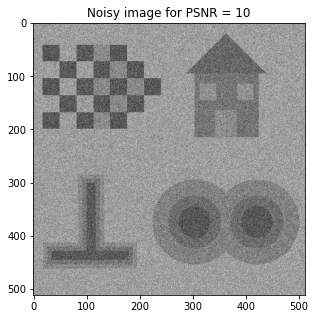

In [36]:
############### 1.1.2 ############### 
# Function that makes the noisy image
def noisy(PSNR,img):
    row,col= img.shape
    mean = 0
    sigma = (img.max()-img.min())/(10**(PSNR/20))
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy_img = img + gauss
    #noisy_img = noisy_img.astype(np.float)/noisy_img.max() # Normalize to [0,1]
    return noisy_img

NOISY_IMG = [] # list to append noisy images for different PSNR values
PSNR = [20,10]
for psnr in PSNR:
    noisy_img = noisy(psnr,img)
    NOISY_IMG.append(noisy_img) # Append to list with noisy images
    # Show image
    plt.figure(figsize=(10,5))
    plt.title('Noisy image for PSNR = {}'.format(psnr))
    plt.imshow(noisy_img, cmap='gray') # print image for check
    plt.show()

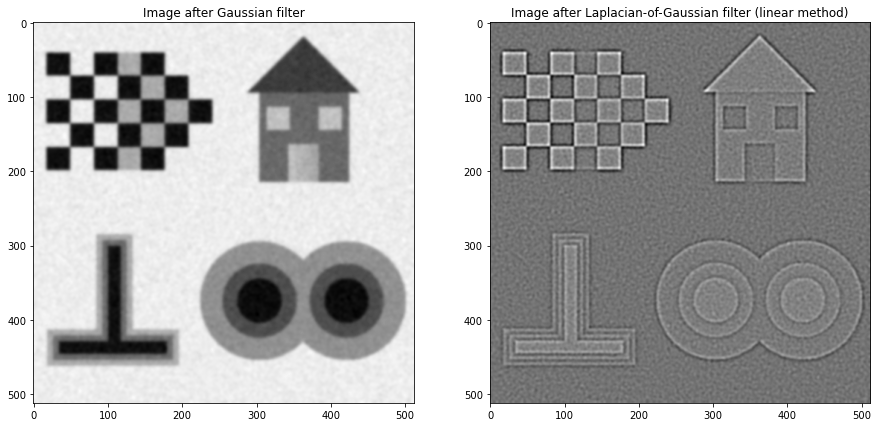

In [37]:
############### 1.2.1 ###############
# The 2D Gaussian filter 
def Gaussian_2D(sigma):
    n = int(2*np.ceil(3*sigma)+1)
    gauss1D = cv2.getGaussianKernel(n, sigma) # Column vector
    gauss2D = gauss1D @ gauss1D.T # Symmetric gaussian kernel
    return gauss2D # Return the Gaussian_2D filter

## The Laplacian-of-Gaussian filter (NOT THE BEST APPROCH) - WE DONT USE IT
###########################################################################
#def LoG(sigma):
#    laplaceian = np.array([[ 0,-1, 0],
#                           [-1, 4,-1],
#                           [ 0,-1, 0]]) # laplacian kernel
#    gauss2D = Gaussian_2D(sigma)
#    log = cv2.filter2D(gauss2D, -1, laplaceian)
#    return log # Return the LoG filter
###########################################################################


# The Laplacian-of-Gaussian filter (THE BEST APPROCH)
def LoG(sigma):
    n = int(2*np.ceil(3*sigma)+1)
    coords = np.arange(-n//2, n//2, 1)
    xx, yy = np.meshgrid(coords, coords, sparse=True)
    h = xx**2+yy**2
    #log = ((2*sigma**2-h)/(2*np.pi*sigma**6))*np.exp(-h/(2*sigma**2))
    log = ((h-2*sigma**2)/(2*np.pi*sigma**6))*np.exp(-h/(2*sigma**2)) # type from maths
    return log # Return the LoG filter

noisy_img=NOISY_IMG[0] # choose a noise image to see results

plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.title('Image after Gaussian filter')
img_smooth_1 = cv2.filter2D(noisy_img, -1, Gaussian_2D(2))
plt.imshow(img_smooth_1, cmap='gray') # print image for check

plt.subplot(1,2,2)
plt.title('Image after Laplacian-of-Gaussian filter (linear method)')
img_smooth_2 = cv2.filter2D(noisy_img, -1, LoG(2))
plt.imshow(img_smooth_2, cmap='gray') # print image for check
plt.show()

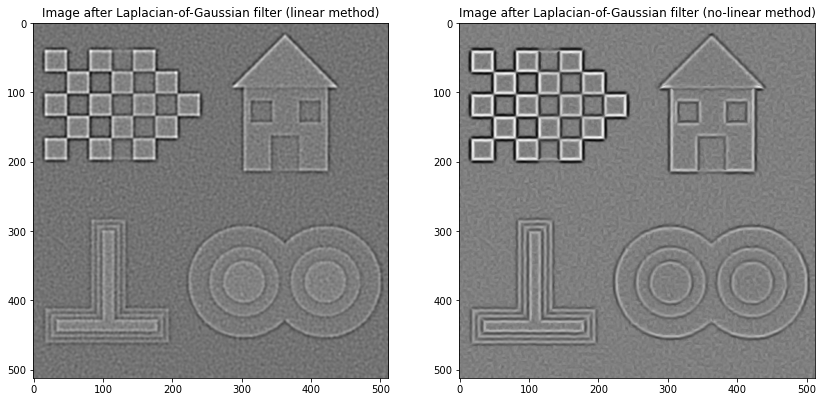

In [38]:
############### 1.2.2 ###############
##### question i #####
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Image after Laplacian-of-Gaussian filter (linear method)')
img_smooth_linear = cv2.filter2D(noisy_img, -1, LoG(2))
plt.imshow(img_smooth_linear, cmap='gray') # print image for check

##### question ii #####
def LoG_nolinear(sigma,img):
    img_gaussian = cv2.filter2D(img, -1, Gaussian_2D(sigma)) # image aftes gaussina filtering
    
    kern = np.array([
        [0,1,0],
        [1,1,1],
        [0,1,0]
    ], dtype=np.uint8) # Create morphological kernel
    dilated_img = cv2.dilate(img_gaussian, kern) # Perform dilation
    eroded_img = cv2.erode(img_gaussian, kern) # Perform Erosion
    return dilated_img + eroded_img - 2*img_gaussian # calculate the given type

plt.subplot(1,2,2)
plt.title('Image after Laplacian-of-Gaussian filter (no-linear method)')
img_smooth_nolinear = LoG_nolinear(2,noisy_img)
plt.imshow(img_smooth_nolinear, cmap='gray') # print image for check
plt.show()

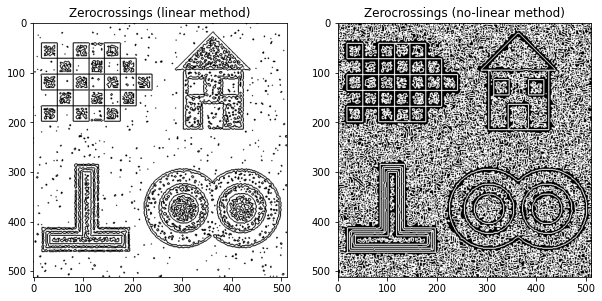

In [39]:
############### 1.2.3 ###############
def zerocrossings(img,threshold=0):
    # Convert to binary with thresholding
    _, binary_img = cv2.threshold(img, threshold, 1, cv2.THRESH_BINARY) # Threshold default value == 0
 
    # Define Y
    kern = np.array([
        [0,1,0],
        [1,1,1],
        [0,1,0]
    ], dtype=np.uint8) # Create morphological kernel
    dilated_img = cv2.dilate(binary_img, kern) # Perform dilation
    eroded_img = cv2.erode(binary_img, kern) # Perform erosion
    Y = dilated_img - eroded_img

    # Define zerocrossings
    zerocrossing_img = np.zeros(img.shape) # Intialize empty image
    line,row = np.where(Y==1) # Find where Y==1
    cords = np.stack((line,row),axis=1) # Combine line and row to define coordinates
    for (i,j) in cords:
        zerocrossing_img[i,j]=1 # Put 1 in the correct positions
        
    return zerocrossing_img


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Zerocrossings (linear method)')
img_0 = zerocrossings(img_smooth_linear)
plt.imshow(img_0, cmap='gray_r') # print image for check

plt.subplot(1,2,2)
plt.title('Zerocrossings (no-linear method)')
img_1 = zerocrossings(img_smooth_nolinear)
plt.imshow(img_1, cmap='gray') # print image for check
plt.show()

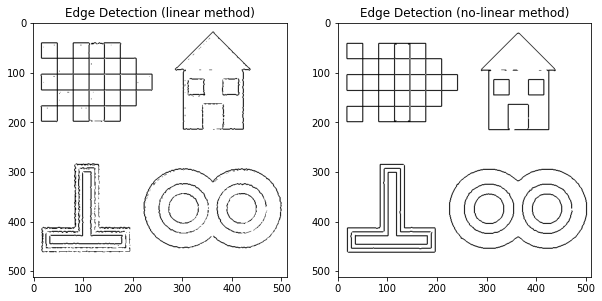

In [40]:
############### 1.2.4 ###############
from numpy import linalg as LA

# Function that calculates the first partial derivative of the gaussian image as a kernel to be applied -- WE DONT USE IT BECAUSE IT GIVES WORSE RESULTS
########################################################################################################################################################
#def grads(sigma):
#    n = int(2*np.ceil(3*sigma)+1)
#    coords = np.arange(-n//2, n//2, 1)
#    xx, yy = np.meshgrid(coords, coords, sparse=True)
#    h = xx**2+yy**2
#    gradx = -(xx/(2*np.pi*sigma**4))*np.exp(-h/(2*sigma**2))
#    grady = -(yy/(2*np.pi*sigma**4))*np.exp(-h/(2*sigma**2))
#    return gradx,grady # Return the LoG filter
########################################################################################################################################################

def EdgeDetect(I,sigma,theta,type_of_Laplacian):
    # Define image aftes Gaussian filtering
    I_s =  cv2.filter2D(I, -1, Gaussian_2D(sigma))
    
    # Define image after LoG
    if type_of_Laplacian == 'linear': 
        L = cv2.filter2D(I, -1, LoG(sigma)) # TYPE = linear
    else:                            
        L = LoG_nolinear(sigma,I) # TYPE = no_linear
    
    # Define Y
    Y = zerocrossings(L)
    
    ####### calculation from made function #######
    #gradx,grady = grads(sigma)
    #grad_x = cv2.filter2D(I, -1, gradx)
    #grad_y = cv2.filter2D(I, -1, grady)
    #norm = np.sqrt(grad_x**2+grad_y**2)
    #############################################
    
    
    # Define gradient -- Find where condition applies
    #grad_x,grad_y = np.gradient(I_s) # gradient of image after Gaussian filtering
    #norm = np.sqrt(grad_x**2+grad_y**2) # calculate the L2 norm
    
    gradient = np.gradient(I_s) # gradient of image after Gaussian filtering
    norm = LA.norm(gradient, axis=0) # calculate the L2 norm
    line,row = np.where(norm > theta*(norm.max())) # Find where the given condition applies
    cords = np.stack((line,row),axis=1) # Combine line and row to define coordinates
    
    # Define final imgae
    final_img = np.zeros(I.shape) # Intialize empty image
    for (i,j) in cords:
        if Y[i,j] == 1:
            final_img[i,j]=1 # Put 1 in the correct positions
            
    return final_img


I = NOISY_IMG[0] # selected image eith PSNR=20
sigma = 2
theta = 0.2

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Edge Detection (linear method)')
img_0 = EdgeDetect(I,sigma,theta,'linear')
plt.imshow(img_0, cmap='gray_r') # print image for check

plt.subplot(1,2,2)
plt.title('Edge Detection (no-linear method)')
img_1 = EdgeDetect(I,sigma,theta,'no_linear')
plt.imshow(img_1, cmap='gray_r') # print image for check
plt.show()   

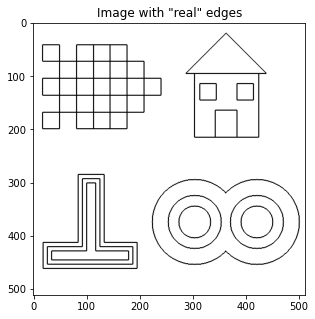

In [41]:
############### 1.3.1 ###############
def RealEdgeDetect(img,theta_real):
    # Define M
    kern = np.array([
        [0,1,0],
        [1,1,1],
        [0,1,0]
    ], dtype=np.uint8) # Create morphological kernel
    dilated_img = cv2.dilate(img, kern) # Perform dilation
    eroded_img = cv2.erode(img, kern) #  Perform erosion
    M = dilated_img - eroded_img
    
    #T = np.zeros(img.shape) # Intialize empty image
    #line,row = np.where(M > theta_real) # Find where M > threshold
    #cords = np.stack((line,row),axis=1) # Combine line and row to define coordinates
    #for (i,j) in cords:
    #    T[i,j] = 1 # Put 1 in the positions that the condition applies (make binary image)
    _, T = cv2.threshold(M, theta_real, 1, cv2.THRESH_BINARY)  # Binary image with "real" edges  
    return T
    
theta_real = 0.15 # threshold
T = RealEdgeDetect(img,theta_real)

plt.figure(figsize=(10,5))
plt.title('Image with "real" edges')
plt.imshow(T, cmap='gray_r') # print image for check
plt.show()

In [42]:
############### 1.3.2 ###############
def EdgeDetectRes(img,theta_real,PSNR,sigma,theta,type_of_Laplacian):
    # Define images
    if PSNR == 'none':
        noisy_img = img
    else:
        noisy_img = noisy(PSNR,img) # make noisy image
    D = EdgeDetect(noisy_img,sigma,theta,type_of_Laplacian) # define image from "EdgeDetect"
    T = RealEdgeDetect(img,theta_real) # define image from "RealEdgeDetect"
    D = D.astype(int)
    T = T.astype(int)
    
    # Calculate probabilities
    P = np.sum(T&D) # card[D (intersection) T] = card[T (intersection) D]
    P_T = np.sum(T) # card(T)
    P_D = np.sum(D) # card(D)
    
    C = (1/P_T +1/P_D)*P/2
    return C

theta_real = 0.15
PSNR = 20
sigma = 1.5
theta= 0.2
type_of_Laplacian = 'linear' 

rr = EdgeDetectRes(img,theta_real,PSNR,sigma,theta,type_of_Laplacian)
print('Similarity score is: C = {}'.format(rr))

Similarity score is: C = 0.5249684100861848


PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = (0.15, 20, 1.5, 0.2)
Images:


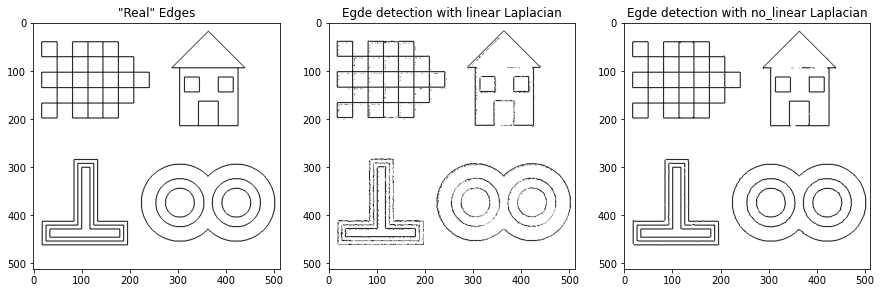

Similarity score for "Real" and "linear" is: 0.532104477843763
Similarity score for "Real" and "no_linear" is: 0.9674209201739294


PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = (0.15, 10, 3, 0.2)
Images:


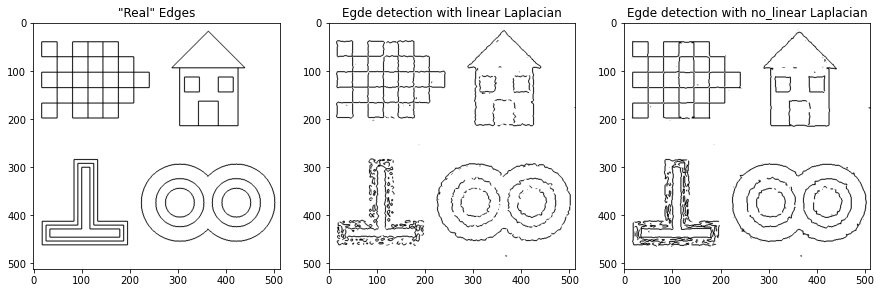

Similarity score for "Real" and "linear" is: 0.4036253009678172
Similarity score for "Real" and "no_linear" is: 0.7437976061474766


In [43]:
############### 1.3.3 ###############
##### question A #####
print('PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = (0.15, 20, 1.5, 0.2)')
print('Images:')
plt.figure(figsize=(15,7.5))
plt.subplot(1,3,1)
plt.imshow(RealEdgeDetect(img,0.15), cmap='gray_r') # print image with real edges
plt.title('"Real" Edges')

plt.subplot(1,3,2)
I = noisy(20,img) # make noisy image
plt.imshow( EdgeDetect(I,1.5,0.2,'linear'), cmap='gray_r') # print smoothend image with linear Laplacian
plt.title('Egde detection with linear Laplacian')

plt.subplot(1,3,3)
plt.imshow( EdgeDetect(I,1.5,0.2,'no_linear'), cmap='gray_r') # print smoothend image with no_linear Laplacian
plt.title('Egde detection with no_linear Laplacian')
plt.show()

print('Similarity score for "Real" and "linear" is: {}'.format(EdgeDetectRes(img, 0.15, 20, 1.5, 0.2, 'linear')))
print('Similarity score for "Real" and "no_linear" is: {}\n\n'.format(EdgeDetectRes(img, 0.15, 20, 1.5, 0.2, 'no_linear')))


##### question B #####
print('PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = (0.15, 10, 3, 0.2)')
print('Images:')
plt.figure(figsize=(15,7.5))
plt.subplot(1,3,1)
plt.imshow(RealEdgeDetect(img,0.15), cmap='gray_r') # print image with real edges
plt.title('"Real" Edges')

plt.subplot(1,3,2)
I = noisy(10,img) # make noisy image
plt.imshow( EdgeDetect(I,3,0.2,'linear'), cmap='gray_r') # print smoothend image with linear Laplacian
plt.title('Egde detection with linear Laplacian')

plt.subplot(1,3,3)
plt.imshow( EdgeDetect(I,3,0.2,'no_linear'), cmap='gray_r') # print smoothend image with no_linear Laplacian
plt.title('Egde detection with no_linear Laplacian')
plt.show()

print('Similarity score for "Real" and "linear" is: {}'.format(EdgeDetectRes(img, 0.15, 10, 3, 0.2, 'linear')))
print('Similarity score for "Real" and "no_linear" is: {}'.format(EdgeDetectRes(img, 0.15, 10, 3, 0.2, 'no_linear')))

PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = (0.11, 110, 0.65, 0.25)
Images:


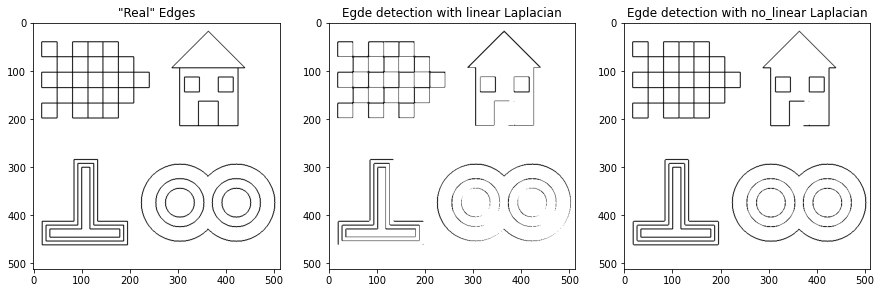

Similarity score for "Real" and "linear" is: 0.815040127791968
Similarity score for "Real" and "no_linear" is: 0.9653198908429351


PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = (0.11, 60, 0.5, 0.15)
Images:


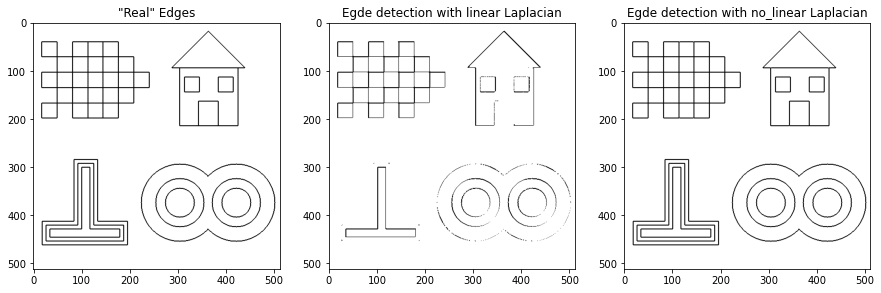

Similarity score for "Real" and "linear" is: 0.7409636192663283
Similarity score for "Real" and "no_linear" is: 0.9997346876895088


In [44]:
##### question C (our rarameters) #####
theta_real = 0.11
PSNR = 110
sigma = 0.65
theta = 0.25

print('PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = ({}, {}, {}, {})'.format(theta_real,PSNR,sigma,theta))
print('Images:')
plt.figure(figsize=(15,7.5))
plt.subplot(1,3,1)
plt.imshow(RealEdgeDetect(img,theta_real), cmap='gray_r') # print image with real edges
plt.title('"Real" Edges')

plt.subplot(1,3,2)
I = noisy(PSNR,img) # make noisy image
plt.imshow( EdgeDetect(I,sigma,theta,'linear'), cmap='gray_r') # print smoothend image with linear Laplacian
plt.title('Egde detection with linear Laplacian')

plt.subplot(1,3,3)
plt.imshow( EdgeDetect(I,sigma,theta,'no_linear'), cmap='gray_r') # print smoothend image with no_linear Laplacian
plt.title('Egde detection with no_linear Laplacian')
plt.show()

print('Similarity score for "Real" and "linear" is: {}'.format(EdgeDetectRes(img, theta_real,PSNR,sigma,theta, 'linear')))
print('Similarity score for "Real" and "no_linear" is: {}\n\n'.format(EdgeDetectRes(img, theta_real,PSNR,sigma,theta, 'no_linear')))


theta_real = 0.11
PSNR = 60
sigma = 0.5
theta = 0.15

print('PARAMETERS VALUE: (θ_real, PSNR, σ, θ_edge) = ({}, {}, {}, {})'.format(theta_real,PSNR,sigma,theta))
print('Images:')
plt.figure(figsize=(15,7.5))
plt.subplot(1,3,1)
plt.imshow(RealEdgeDetect(img,theta_real), cmap='gray_r') # print image with real edges
plt.title('"Real" Edges')

plt.subplot(1,3,2)
I = noisy(PSNR,img) # make noisy image
plt.imshow( EdgeDetect(I,sigma,theta,'linear'), cmap='gray_r') # print smoothend image with linear Laplacian
plt.title('Egde detection with linear Laplacian')

plt.subplot(1,3,3)
plt.imshow( EdgeDetect(I,sigma,theta,'no_linear'), cmap='gray_r') # print smoothend image with no_linear Laplacian
plt.title('Egde detection with no_linear Laplacian')
plt.show()

print('Similarity score for "Real" and "linear" is: {}'.format(EdgeDetectRes(img, theta_real,PSNR,sigma,theta, 'linear')))
print('Similarity score for "Real" and "no_linear" is: {}'.format(EdgeDetectRes(img, theta_real,PSNR,sigma,theta, 'no_linear')))

Original image:


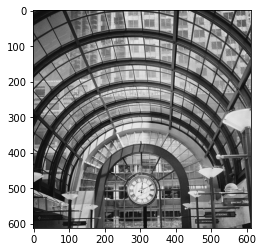

In [45]:
############### 1.4.1 ###############
# read image in grayscale mode
path = '../data/urban_edges.jpg'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

# Normalize to [0,1]
img = img.astype(np.float)/255

# Show image in grayscale
print('Original image:')
plt.imshow(img, cmap='gray') # print image for check
plt.show()

PARAMETERS VALUE: (θ_real, σ, θ_edge) = (0.2, 0.51, 0.16)
Images:


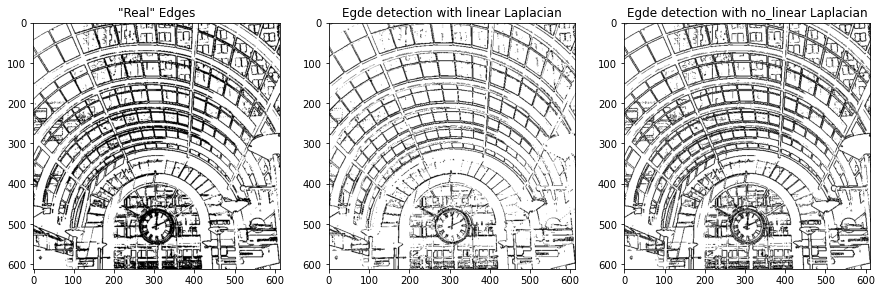

Similarity score for "Real" and "linear" is: 0.7378636643132921
Similarity score for "Real" and "no_linear" is: 0.8731060932930755


In [46]:
##### 1.4.1/1.4.2 #####
theta_real = 0.2
PSNR = 'none' # because we don't have noise
sigma = 0.51
theta = 0.16

print('PARAMETERS VALUE: (θ_real, σ, θ_edge) = ({}, {}, {})'.format(theta_real,sigma,theta))
print('Images:')
plt.figure(figsize=(15,7.5))
plt.subplot(1,3,1)
plt.imshow(RealEdgeDetect(img,theta_real), cmap='gray_r') # print image with real edges
plt.title('"Real" Edges')

plt.subplot(1,3,2)
plt.imshow( EdgeDetect(img,sigma,theta,'linear'), cmap='gray_r') # print smoothend image with linear Laplacian
plt.title('Egde detection with linear Laplacian')

plt.subplot(1,3,3)
plt.imshow( EdgeDetect(img,sigma,theta,'no_linear'), cmap='gray_r') # print smoothend image with no_linear Laplacian
plt.title('Egde detection with no_linear Laplacian')
plt.show()

print('Similarity score for "Real" and "linear" is: {}'.format(EdgeDetectRes(img,theta_real,PSNR,sigma,theta, 'linear')))
print('Similarity score for "Real" and "no_linear" is: {}'.format(EdgeDetectRes(img,theta_real,PSNR,sigma,theta, 'no_linear')))

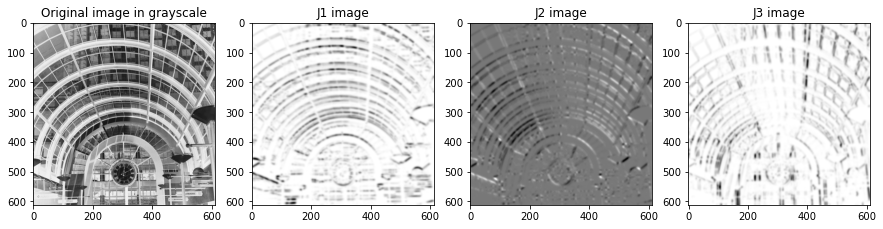

In [47]:
############### PART 2 ############### 
############### 2.1.1 ############### 
def DefineJ(I,sigma,r):
    Gr = Gaussian_2D(r) # define Gr
    Is = cv2.filter2D(I, -1, Gaussian_2D(sigma)) # Gaussian image
    grad_x,grad_y = np.gradient(Is) # gradients of image after Gaussian filtering
    
    ####### calculation from made function #######
    #gradx,grady = grads(sigma)
    #grad_x = cv2.filter2D(I, -1, gradx)
    #grad_y = cv2.filter2D(I, -1, grady)
    #############################################    
    
    # Calculate J1, J2, J3 from the given type
    J1 = cv2.filter2D(grad_x*grad_x, -1, Gr)
    J2 = cv2.filter2D(grad_x*grad_y, -1, Gr)
    J3 = cv2.filter2D(grad_y*grad_y, -1, Gr)
    return J1,J2,J3

# read image in grayscale mode
path = '../data/urban_edges.jpg'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
J1,J2,J3 = DefineJ(img,2,2.5)

plt.figure(figsize=(15,7.5))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray_r') # J1 image
plt.title('Original image in grayscale')

plt.subplot(1,4,2)
plt.imshow(J1, cmap='gray_r') # J1 image
plt.title('J1 image')

plt.subplot(1,4,3)
plt.imshow(J2, cmap='gray_r') # J2 image
plt.title('J2 image')

plt.subplot(1,4,4)
plt.imshow(J3, cmap='gray_r') # J3 image
plt.title('J3 image')
plt.show()

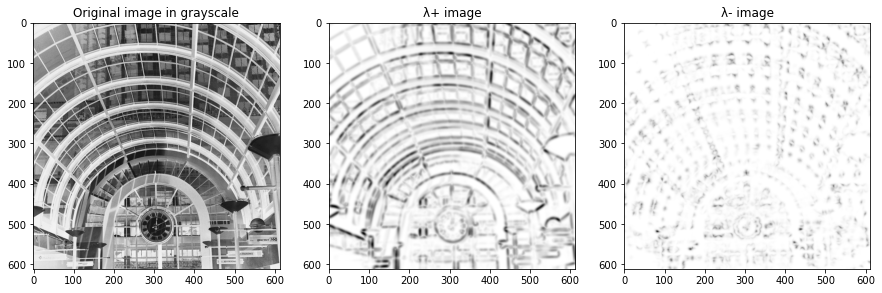

In [48]:
############### 2.1.2 ############### 
def Definelamdas(I,sigma,r):
    J1,J2,J3 = DefineJ(I,sigma,r) # Define J1,J2,J3 from the previous function
    # Calculate lamdas srom given type
    lamda_1 = (J1+J3+np.sqrt((J1-J3)**2 + 4*J2**2))/2
    lamda_2 = (J1+J3-np.sqrt((J1-J3)**2 + 4*J2**2))/2
    return lamda_1,lamda_2

lamda1,lamda2 = Definelamdas(img,2,2.5)

plt.figure(figsize=(15,7.5))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray_r') # J1 image
plt.title('Original image in grayscale')

plt.subplot(1,3,2)
plt.imshow(lamda1, cmap='gray_r') # J1 image
plt.title('λ+ image')

plt.subplot(1,3,3)
plt.imshow(lamda2, cmap='gray_r') # J2 image
plt.title('λ- image')
plt.show()

Resluts for 'urban_edges.jpg':


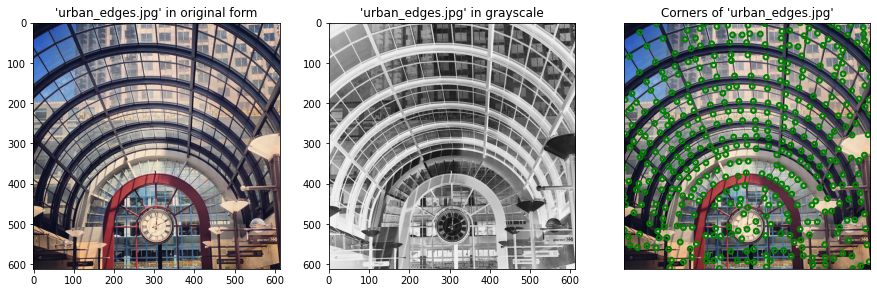



Resluts for 'blood_smear.jpg':


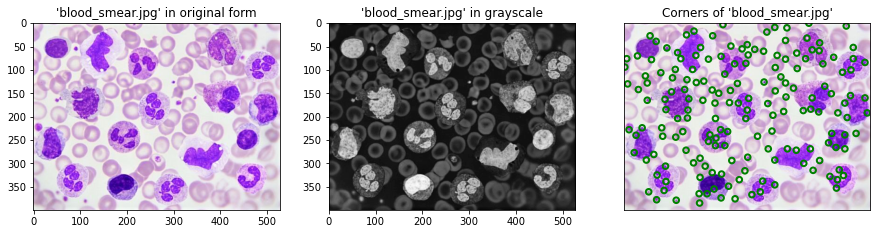



Resluts for 'mars.png':


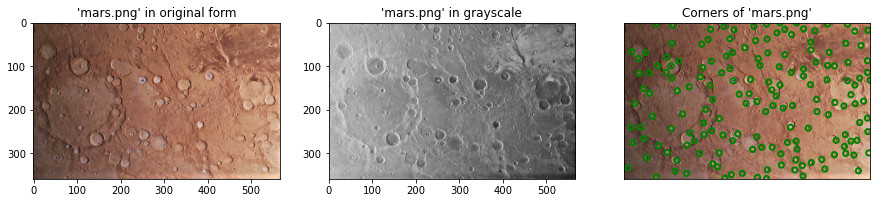

In [49]:
############### 2.1.3 ############### 
from cv21_lab1_part2_utils import interest_points_visualization
from cv21_lab1_part2_utils import disk_strel

def CornerDetect(I,sigma,r,k,theta_corn):
    lamda_1,lamda_2 = Definelamdas(I,sigma,r) # define lamdaw from previouw function
    R = lamda_1*lamda_2 - k*(lamda_1+lamda_2)**2  # calcylate R from given type

    ##### Condition S1 #####
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = (R==cv2.dilate(R,B_sq))
    
    ##### Condition S2 #####
    Cond2 = (R>theta_corn*R.max())
    
    final = Cond1&Cond2 # combine the 2 conditions
    final = final.astype(int)
    return final 

# Function that return arrays in the correct form to be used from "interest_points_visualization"
def InterestPoints(img,sigma):
    coordy, coordx = np.where(img==1)
    ss = np.ones(coordx.shape)*sigma
    elem_intrst = np.stack((coordx, coordy,ss),axis=1)
    return elem_intrst

IMAGE = ['../data/urban_edges.jpg', '../data/blood_smear.jpg', '../data/mars.png']
sigma = 2
r = 2.5
k = 0.05
theta_corn = 0.005

for img_name in IMAGE:
    print("Resluts for '{}':".format(img_name))
    img_OG = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15,7.5))
    plt.subplot(1,3,1)
    plt.imshow(img_OG)
    plt.title("'{}' in original form".format(img_name))
    
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,3,2)
    plt.imshow(img, cmap='gray_r')
    plt.title("'{}' in grayscale".format(img_name))
    
    intrst_elems = InterestPoints(CornerDetect(img,sigma,r,k,theta_corn),sigma)
    interest_points_visualization(img_OG, intrst_elems,plt.subplot(1,3,3))
    plt.title("Corners of '{}'".format(img_name))
    plt.show()
    print('\n')

Resluts for 'blood_smear.jpg':


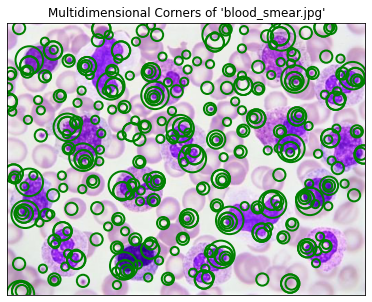



Resluts for 'mars.png':


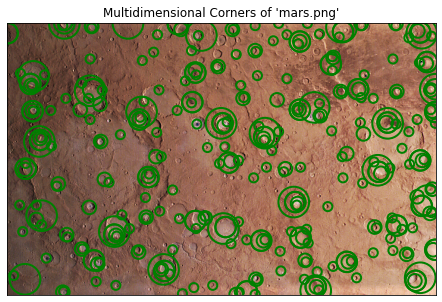

In [50]:
############### 2.2.1 & 2.2.2 ############### 

# Function that calculates the second partial derivatives of the Gaussian image as a kernel, so as to apply the less noise possible
def gradLoG(sigma):
    n = int(2*np.ceil(3*sigma)+1)
    coords = np.arange(-n//2, n//2, 1)
    xx, yy = np.meshgrid(coords, coords, sparse=True)
    h = xx**2+yy**2
    logxx = ((xx**2-sigma**2)/(2*np.pi*sigma**6))*np.exp(-h/(2*sigma**2))
    logyy = ((yy**2-sigma**2)/(2*np.pi*sigma**6))*np.exp(-h/(2*sigma**2))
    logxy = ((xx*yy)/(2*np.pi*sigma**6))*np.exp(-h/(2*sigma**2))
    return logxx, logyy, logxy # Return the LoG filter

def MultiDimCornerDetectPrep(I,sigma,r,k,theta_corn,s,N):
    dictionary_s = {}
    for i in range (0,N,1):
        sigma_n = (s**i)*sigma
        r_n = (s**i)*r
        
        #I_s = cv2.filter2D(I, -1, Gaussian_2D(sigma_n))
        #gradxx,gradyy = np.gradient(I_s,edge_order=2) # define grads using the built-in function
        #log_s = sigma_n**2 * np.abs(gradxx + gradyy)
        
        # calculate grads from made function as to avoid appling more noise
        logxx,logyy,_ = gradLoG(sigma_n)
        log_s = sigma_n**2 * np.abs(cv2.filter2D(I, -1, logxx)+cv2.filter2D(I, -1, logyy))
        
        dictionary_s[sigma_n] = (CornerDetect(I,sigma_n,r_n,k,theta_corn),log_s) # dictionary to be used it the following function

    return dictionary_s


def MultiDimCornerDetect(I,sigma,r,k,theta_corn,s,N):
    dic = MultiDimCornerDetectPrep(I,sigma,r,k,theta_corn,s,N)
    
    fin_table = []
    for q in range (0,N-1,1):
        # Extreme Cases - First and Last -- Comparison between 2 points
        if (q==0) or (q==N-2):   
            s1 = (s**q)*sigma # 1st point for comparison
            s2 = s*s1 # 2nd point for comparison
            
            # keep the local maximum
            for i in range (0,dic[s1][0].shape[0]):
                for j in range (0,dic[s1][0].shape[1]):
                    if (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==0):
                        fin_table.append((j,i,s1))
                    elif (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1):
                        fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1):
                        if(dic[s1][1][i,j] > dic[s2][1][i,j]):
                            fin_table.append((j,i,s1))
                        else:
                            fin_table.append((j,i,s2))
        
        # All the other cases -- Comparison between 3 points
        else:
            s1 = (s**q)*sigma # 1st point for comparison
            s2 = s*s1 # 2nd point for comparison
            s3 = s*s2 # 3rd point for comparison
            
            # keep only if the middle point is local maximum
            for i in range (0,dic[s1][0].shape[0]):
                for j in range (0,dic[s1][0].shape[1]):
                    if (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==0):
                        fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==0):
                        if(dic[s2][1][i,j] >= dic[s1][1][i,j]):
                            fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==1):
                        if(dic[s2][1][i,j] >= dic[s3][1][i,j]):
                            fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==1):
                        if((dic[s2][1][i,j] >= dic[s1][1][i,j]) and (dic[s2][1][i,j] >= dic[s3][1][i,j])):
                            fin_table.append((j,i,s2))                    
                        
    return np.array(fin_table)                    
                    
            
    
IMAGE = ['../data/blood_smear.jpg', '../data/mars.png']
sigma = 2
r = 2.5
k = 0.05
theta_corn = 0.005
s = 1.5
N = 4

for img_name in IMAGE:
    print("Resluts for '{}':".format(img_name))
    img_OG = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)  
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    fig, axes = plt.subplots(figsize=(10,5))
    
    multi_intrst_elems = MultiDimCornerDetect(img,sigma,r,k,theta_corn,s,N)
    interest_points_visualization(img_OG, multi_intrst_elems,axes)
    plt.title("Multidimensional Corners of '{}'".format(img_name))
    plt.show()
    print('\n')

Resluts for 'blood_smear.jpg':


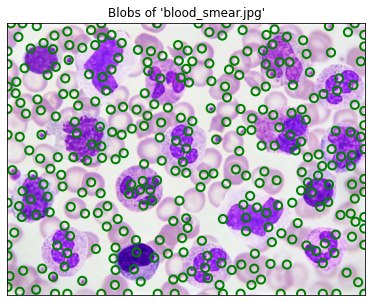



Resluts for 'mars.png':


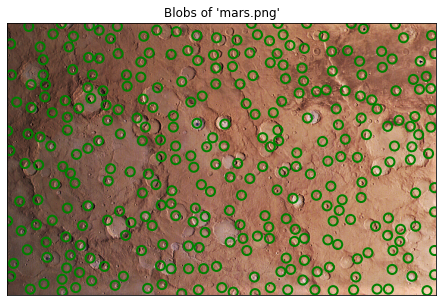

In [51]:
############### 2.3.1 & 2.3.2 ############### 
from scipy.signal import argrelextrema

def BlobDetect(img,sigma,thr):
    #I_s = cv2.filter2D(I, -1, Gaussian_2D(sigma))
    #gradxx,gradyy = np.gradient(I_s,edge_order=2) # define grads using the built-in function
    #gradxy = np.gradient(np.gradient(I_s)[1])[0] # It's equal to "gradyx = np.gradient(np.gradient(img)[0])[1]"
    
    logxx,logyy,logxy = gradLoG(sigma) # define grads from our made-function
    Ixx = cv2.filter2D(img, -1, logxx)
    Iyy = cv2.filter2D(img, -1, logyy)
    Ixy = cv2.filter2D(img, -1, logxy)
    
    H = np.array([[Ixx,Ixy],[Ixy,Iyy]]) # Calculate matrix H 
    
    R = np.zeros((H.shape[2],H.shape[3])) # Define R for each pixel
    for i in range (0, H.shape[2]):
        for j in range (0, H.shape[3]):
            R[i,j] =np.linalg.det(H[:,:,i,j])

            
    ##### Condition S1 #####
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = (R==cv2.dilate(R,B_sq))
    
    #Cond1=np.full(R.shape, True, dtype=bool)
    #line,row = argrelextrema(R,np.greater)
    #cords = np.stack((line,row),axis=1)
    #for (i,j) in cords:
    #    Cond1[i,j]=True
        
    ##### Condition S2 #####
    Cond2 = (R>thr*R.max())
   
    final = Cond1&Cond2 # comdine the 2 conditions
    final = final.astype(int)
    return R,final

#def InterestBlobs(img,sigma):
#    coordy, coordx = np.where(img==1)
#    ss = np.ones(coordx.shape)*sigma
#    elem_intrst = np.stack((coordx, coordy,ss),axis=1)
#    return elem_intrst


sigma = 2
thr=0.005
    
IMAGE = ['../data/blood_smear.jpg','../data/mars.png']
for img_name in IMAGE:
    print("Resluts for '{}':".format(img_name))
    img_OG = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB) 
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float)/255
    
    fig, axes = plt.subplots(figsize=(10,5))
    
    intrst_elems = InterestPoints(BlobDetect(img,sigma,thr)[1],sigma)
    interest_points_visualization(img_OG, intrst_elems,axes)
    plt.title("Blobs of '{}'".format(img_name))
    plt.show()
    print('\n')

Resluts for 'blood_smear.jpg':


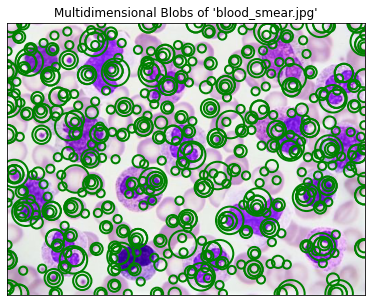



Resluts for 'mars.png':


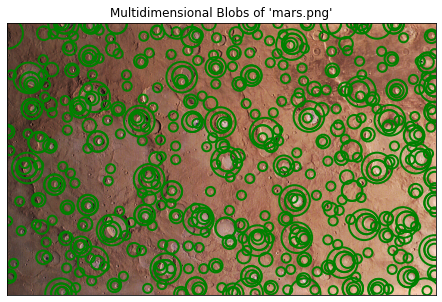

In [52]:
############### 2.4.1 ############### 
def MultiDimBlobDetectPrep(I,sigma,thr,s,N):
    dictionary_s = {}
    for i in range (0,N,1):
        sigma_n = (s**i)*sigma
        
        #I_s = cv2.filter2D(I, -1, Gaussian_2D(sigma_n))
        #gradxx,gradyy = np.gradient(I_s,edge_order=2) # define grads using the built-in function
        #log_s = sigma_n**2 * np.abs(gradxx + gradyy)
        
        logxx,logyy,_ = gradLoG(sigma_n) # define grads from our made-function
        log_s = sigma_n**2 * np.abs(cv2.filter2D(I, -1, logxx)+cv2.filter2D(I, -1, logyy))
        
        dictionary_s[sigma_n] = (BlobDetect(I,sigma_n,thr)[1],log_s) # dictionary to be used it the following function

    return dictionary_s


def MultiDimBlobDetect(I,sigma,thr,s,N):
    dic = MultiDimBlobDetectPrep(I,sigma,thr,s,N)
    
    fin_table = []
    for q in range (0,N-1,1):
        # Extreme Cases - First and Last -- Comparison between 2 points
        if (q==0) or (q==N-2):   
            s1 = (s**q)*sigma # 1st point for comparison
            s2 = s*s1 # 2nd point for comparison
            
            # keep the local maximum
            for i in range (0,dic[s1][0].shape[0]):
                for j in range (0,dic[s1][0].shape[1]):
                    if (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==0):
                        fin_table.append((j,i,s1))
                    elif (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1):
                        fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1):
                        if(dic[s1][1][i,j] > dic[s2][1][i,j]):
                            fin_table.append((j,i,s1))
                        else:
                            fin_table.append((j,i,s2))
        
        else:
            s1 = (s**q)*sigma # 1st point for comparison
            s2 = s*s1 # 2nd point for comparison
            s3 = s*s2 # 3rd point for comparison
            
            # keep only if the middle point is local maximum
            for i in range (0,dic[s1][0].shape[0]):
                for j in range (0,dic[s1][0].shape[1]):
                    if (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==0):
                        fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==0):
                        if(dic[s2][1][i,j] >= dic[s1][1][i,j]):
                            fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==1):
                        if(dic[s2][1][i,j] >= dic[s3][1][i,j]):
                            fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==1):
                        if((dic[s2][1][i,j] >= dic[s1][1][i,j]) and (dic[s2][1][i,j] >= dic[s3][1][i,j])):
                            fin_table.append((j,i,s2))                    
                        
    return np.array(fin_table)                 
                    
            
    
IMAGE = ['../data/blood_smear.jpg', '../data/mars.png']
sigma = 2
thr = 0.05
s = 1.5
N = 4

for img_name in IMAGE:
    print("Resluts for '{}':".format(img_name))
    img_OG = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float)/255

    fig, axes = plt.subplots(figsize=(10,5))
    
    multi_intrst_elems = MultiDimBlobDetect(img,sigma,thr,s,N)
    interest_points_visualization(img_OG, multi_intrst_elems,axes)
    plt.title("Multidimensional Blobs of '{}'".format(img_name))
    plt.show()
    print('\n')

In [53]:
############### 2.5.1 & 2.5.2 & 2.5.3 ############### 
import math

def SpeedUpBlobDetect(I,sigma,thr):
    #img = cv2.filter2D(I, -1, Gaussian_2D(sigma))
    
    ############### 2.5.1 ############### 
    #img_integral = np.cumsum(np.cumsum(img,axis=0),axis=1) # Define integral image
    S = np.cumsum(np.cumsum(I, axis = 1), axis=0)
    #img_integral = img_integral/img_integral.max()
    
    ############### 2.5.2 ############### 
    n = int(2*np.ceil(3*sigma)+1)
    height_xx = (4 * math.floor(n/6)) + 1
    width_xx = (2 * math.floor(n/6)) + 1
    height2_xx = math.floor(height_xx/2)
    width2_xx = math.floor(width_xx/2)
    height_yy = (2 * math.floor(n/6)) + 1
    width_yy = (4 * math.floor(n/6)) + 1
    height2_yy = math.floor(height_yy/2)
    width2_yy = math.floor(width_yy/2)
    height = (2 * math.floor(n/6)) + 1
    
    Dxx = np.zeros([I.shape[0], I.shape[1]])
    Dyy = np.zeros([I.shape[0], I.shape[1]])
    Dxy = np.zeros([I.shape[0], I.shape[1]])
    
    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            if (x-height_xx-height2_xx >= 0 and y-width_yy-width2_yy >= 0 and y+width_yy+width2_yy < I.shape[1] and x+height_xx+height2_xx < I.shape[0]):
                
                #Dxx
                S22 = S[x+height2_xx][y+width2_xx]
                S11 = S[x-height2_xx-1][y-width2_xx-1]
                S12 = S[x-height2_xx-1][y+width2_xx]
                S21 = S[x+height2_xx][y-width2_xx-1]
                
                S1 = S[x+height2_xx][y+width_xx+width2_xx]
                S2 = S[x-height2_xx-1][y-width_xx-width2_xx-1]
                S3 = S[x-height2_xx-1][y+width_xx+width2_xx]
                S4 = S[x+height2_xx][y-width_xx-width2_xx-1]
                
                Dxx[x][y] = -3*(S22+S11-S12-S21) + (S1+S2-S3-S4)
                
                #Dyy
                S22 = S[x+height2_yy][y+width2_yy]
                S11 = S[x-height2_yy-1][y-width2_yy-1]
                S12 = S[x-height2_yy-1][y+width2_yy]
                S21 = S[x+height2_yy][y-width2_yy-1]
                
                S1 = S[x+height2_yy+height_yy][y+width2_yy]#H
                S2 = S[x-height2_yy-height_yy-1][y-width2_yy-1]#A
                S3 = S[x-height2_yy-height_yy-1][y+width2_yy]#B
                S4 = S[x+height2_yy+height_yy][y-width2_yy-1]#G
                
                Dyy[x][y] = -3*(S22+S11-S12-S21) + (S1+S2-S3-S4)
                
                #Dxy
                katwdeksia = S[x+height][y+height]+S[x+1][y+1]-S[x+height][y+1]-S[x+1][height+y]
                panwaristera = S[x-1][y-1]+S[x-height][y-height]-S[x-1][y-height]-S[x-height][y-1]
                panwdeksia = S[x-1][y+height]+S[x-height][y+1]-S[x-1][y+1]-S[x-height][y+height]
                katwaristera = S[x+height][y-1]+S[x+1][y-height]-S[x+1][y-1]-S[x+height][y-height]
                
                Dxy[x][y] = katwdeksia + panwaristera - panwdeksia - katwaristera
    
    R = Dxx*Dyy - (0.9*Dxy)**2
    
    ##### Condition S1 #####
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = (R==cv2.dilate(R,B_sq))
            
    ##### Condition S2 #####
    Cond2 = (R>thr*R.max())
   
    final = Cond1&Cond2 # comdine the 2 conditions
    final = final.astype(int)
    return Dxx,Dyy,Dxy,R,final
    

Resluts for 'blood_smear.jpg':


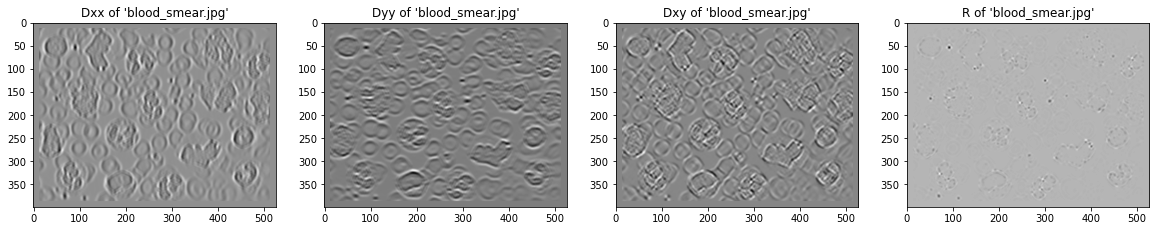



Resluts for 'mars.png':


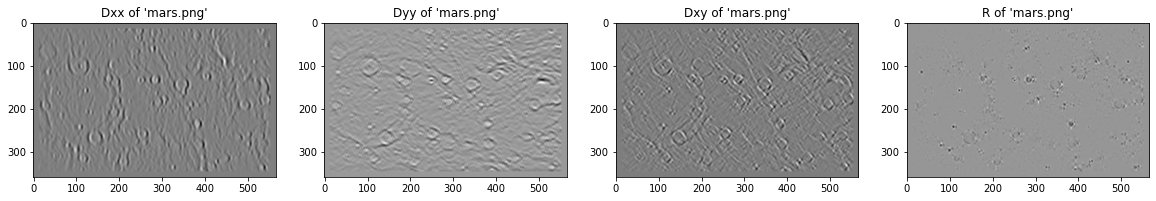

In [54]:
IMAGE = ['../data/blood_smear.jpg', '../data/mars.png']
sigma = 2
thr=0.005

for img_name in IMAGE:
    print("Resluts for '{}':".format(img_name))
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    img = img/img.max()
    Dxx,Dyy,Dxy,R,_ = SpeedUpBlobDetect(img,sigma,thr)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(Dxx, cmap='gray_r')
    plt.title("Dxx of '{}'".format(img_name))
   
    plt.subplot(1,4,2)
    plt.imshow(Dyy, cmap='gray_r')
    plt.title("Dyy of '{}'".format(img_name))
    
    plt.subplot(1,4,3)
    plt.imshow(Dxy, cmap='gray_r')
    plt.title("Dxy of '{}'".format(img_name))
    
    plt.subplot(1,4,4)
    plt.imshow(R, cmap='gray_r')
    plt.title("R of '{}'".format(img_name))
    plt.show()
    print('\n')


Resluts for 'blood_smear.jpg':


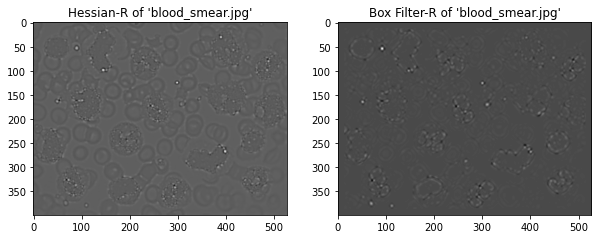



Resluts for 'mars.png':


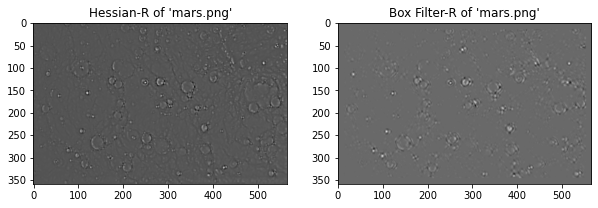

In [55]:
IMAGE = ['../data/blood_smear.jpg', '../data/mars.png']
sigma = 2
thr=0.005

for img_name in IMAGE:
    print("Resluts for '{}':".format(img_name))
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    img = img/img.max()
    Dxx,Dyy,Dxy,R,_ = SpeedUpBlobDetect(img,sigma,thr)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(BlobDetect(img,sigma,thr)[0], cmap='gray')
    plt.title("Hessian-R of '{}'".format(img_name))
   
    plt.subplot(1,2,2)
    plt.imshow(SpeedUpBlobDetect(img,sigma,thr)[3], cmap='gray')
    plt.title("Box Filter-R of '{}'".format(img_name))
    plt.show()
    print('\n')

Resluts for sigma=2:
--> Resluts for 'blood_smear.jpg':


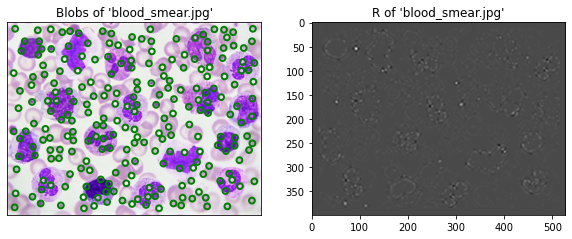

--> Resluts for 'mars.png':


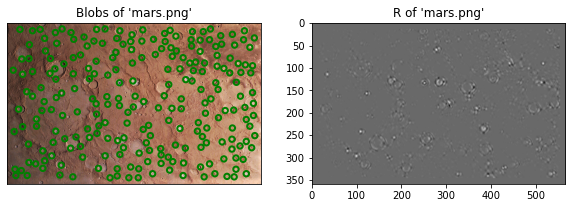



Resluts for sigma=3:
--> Resluts for 'blood_smear.jpg':


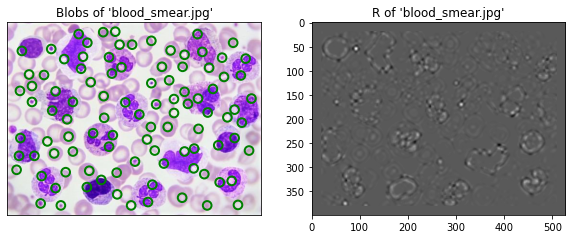

--> Resluts for 'mars.png':


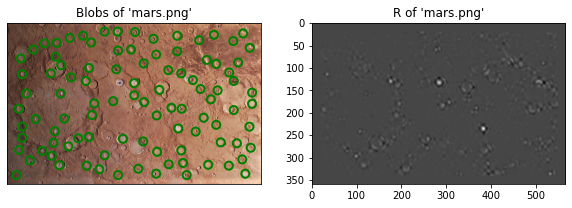



Resluts for sigma=5:
--> Resluts for 'blood_smear.jpg':


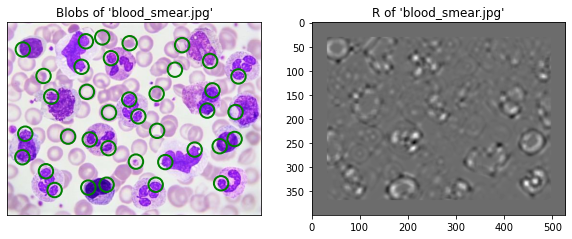

--> Resluts for 'mars.png':


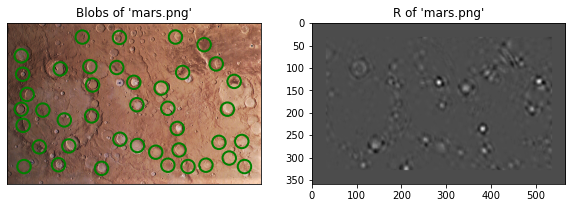



Resluts for sigma=7:
--> Resluts for 'blood_smear.jpg':


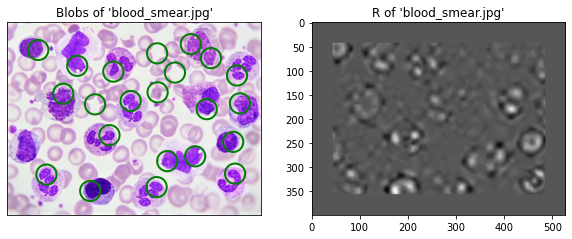

--> Resluts for 'mars.png':


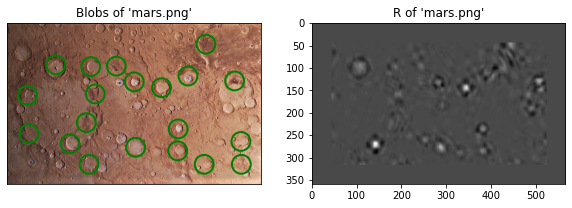



Resluts for sigma=10:
--> Resluts for 'blood_smear.jpg':


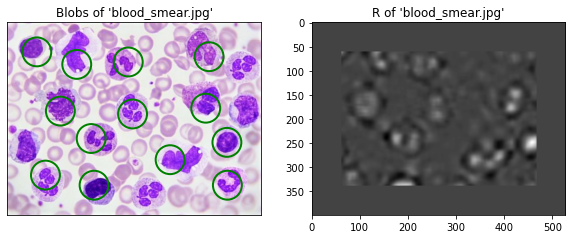

--> Resluts for 'mars.png':


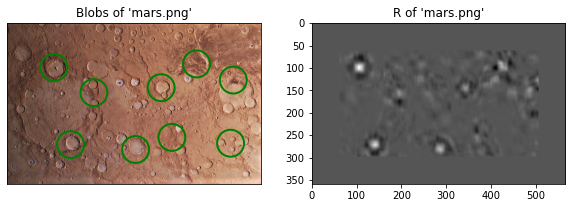

In [56]:
IMAGE = ['../data/blood_smear.jpg', '../data/mars.png']
sigmas = [2,3,5,7,10]
thr=0.005

for sigma in sigmas:
    print("Resluts for sigma={}:".format(sigma))
    for img_name in IMAGE:
        print("--> Resluts for '{}':".format(img_name))
        img_OG = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
        img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float)/255
    
        plt.figure(figsize=(10,5))
        _,_,_,R,fin = SpeedUpBlobDetect(img,sigma,thr)
        speedup_intrst_elems = InterestPoints(fin,sigma)
        interest_points_visualization(img_OG, speedup_intrst_elems,plt.subplot(1,2,1))
        plt.title("Blobs of '{}'".format(img_name))
        
        plt.subplot(1,2,2)
        plt.imshow(R, cmap='gray')
        plt.title("R of '{}'".format(img_name))
        
        plt.show()
    print('\n')
    


Resluts for 'blood_smear.jpg':


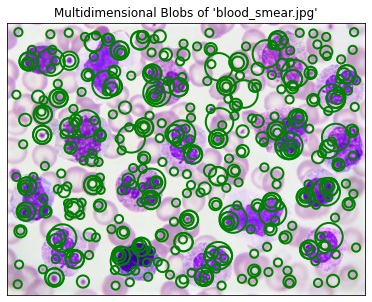



Resluts for 'mars.png':


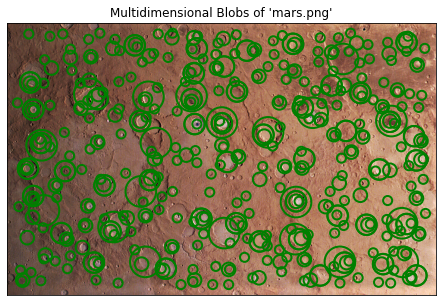

In [57]:
############### 2.5.4 ############### 
def SpeedUpMultiDimBlobDetectPrep(I,sigma,thr,s,N):
    dictionary_s = {}
    for i in range (0,N,1):
        sigma_n = (s**i)*sigma
        
        #I_s = cv2.filter2D(I, -1, Gaussian_2D(sigma_n))
        #gradxx,gradyy = np.gradient(I_s,edge_order=2) # define grads using the built-in function
        #log_s = sigma_n**2 * np.abs(gradxx + gradyy)
        
        logxx,logyy,_ = gradLoG(sigma_n) # define grads from our made-function
        log_s = sigma_n**2 * np.abs(cv2.filter2D(I, -1, logxx)+cv2.filter2D(I, -1, logyy))
        
        dictionary_s[sigma_n] = (SpeedUpBlobDetect(I,sigma_n,thr)[4],log_s) # dictionary to be used it the following function

    return dictionary_s


def SpeedUpMultiDimBlobDetect(I,sigma,thr,s,N):
    dic = SpeedUpMultiDimBlobDetectPrep(I,sigma,thr,s,N)
    
    fin_table = []
    for q in range (0,N-1,1):
        # Extreme Cases - First and Last -- Comparison between 2 points
        if (q==0) or (q==N-2):   
            s1 = (s**q)*sigma # 1st point for comparison
            s2 = s*s1 # 2nd point for comparison
            
            # keep the local maximum
            for i in range (0,dic[s1][0].shape[0]):
                for j in range (0,dic[s1][0].shape[1]):
                    if (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==0):
                        fin_table.append((j,i,s1))
                    elif (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1):
                        fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1):
                        if(dic[s1][1][i,j] > dic[s2][1][i,j]):
                            fin_table.append((j,i,s1))
                        else:
                            fin_table.append((j,i,s2))
        
        else:
            s1 = (s**q)*sigma # 1st point for comparison
            s2 = s*s1 # 2nd point for comparison
            s3 = s*s2 # 3rd point for comparison
            
            # keep only if the middle point is local maximum
            for i in range (0,dic[s1][0].shape[0]):
                for j in range (0,dic[s1][0].shape[1]):
                    if (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==0):
                        fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==0):
                        if(dic[s2][1][i,j] >= dic[s1][1][i,j]):
                            fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==0 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==1):
                        if(dic[s2][1][i,j] >= dic[s3][1][i,j]):
                            fin_table.append((j,i,s2))
                    elif (dic[s1][0][i,j]==1 and dic[s2][0][i,j]==1 and dic[s3][0][i,j]==1):
                        if((dic[s2][1][i,j] >= dic[s1][1][i,j]) and (dic[s2][1][i,j] >= dic[s3][1][i,j])):
                            fin_table.append((j,i,s2))                    
                        
    return np.array(fin_table)                 



IMAGE = ['../data/blood_smear.jpg', '../data/mars.png']
sigma = 2
thr = 0.005
s = 1.5
N = 4

for img_name in IMAGE:
    print("Resluts for '{}':".format(img_name))
    img_OG = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float)/255

    fig, axes = plt.subplots(figsize=(10,5))
    
    multi_intrst_elems = SpeedUpMultiDimBlobDetect(img,sigma,thr,s,N)
    interest_points_visualization(img_OG, multi_intrst_elems,axes)
    plt.title("Multidimensional Blobs of '{}'".format(img_name))
    plt.show()
    print('\n')

In [ ]:
############### PART 3 ############### 
from cv21_lab1_part3_utils import featuresSURF
from cv21_lab1_part3_utils import featuresHOG
from cv21_lab1_part3_utils import matching_evaluation
from cv21_lab1_part3_utils import createTrainTest
from cv21_lab1_part3_utils import BagOfWords
from cv21_lab1_part3_utils import svm
from cv21_lab1_part3_utils import FeatureExtraction

In [ ]:
############### 3.1.1 & 3.1.2 ############### 
def eval_rotation(detector_function, descriptor_function,sigma=2,r=2.5,k=0.05,theta_corn=0.005,s=1.5,N=4):

    # Define detect_fun
    if detector_function == 'CornerDetect':
        detect_fun = lambda I: InterestPoints(CornerDetect(I,sigma,r,k,theta_corn),sigma)
    
    elif detector_function == 'MultiDimCornerDetect':
        detect_fun = lambda I: MultiDimCornerDetect(I,sigma,r,k,theta_corn,s,N)
    
    elif detector_function == 'BlobDetect':
        detect_fun = lambda I: InterestPoints(BlobDetect(I,sigma,thr)[1],sigma)
    
    elif detector_function == 'MultiDimBlobDetect':
        detect_fun = lambda I: MultiDimBlobDetect(I,sigma,thr,s,N)
    
    elif detector_function == 'SpeedUpMultiDimBlobDetect':
        detect_fun = lambda I: SpeedUpMultiDimBlobDetect(I,sigma,thr,s,N)
    
    else:
        #raise BadValueError('Usage: eval_rotation(detector_function, descriptor_function,sigma=2,r=2.5,k=0.05,theta_corn=0.005,s=1.5,N=4),')
        raise ValueError("Choose: detector_function=['CornerDetect','MultiDimCornerDetect','BlobDetect','MultiDimBlobDetect','SpeedUpMultiDimBlobDetect']")
    
    # Define desc_fun
    if descriptor_function == 'SURF':
        desc_fun = lambda I, kp: featuresSURF(I,kp)
    
    elif descriptor_function == 'HOG':
        desc_fun = lambda I, kp: featuresHOG(I,kp)
    
    else:
        raise ValueError("Choose: descriptor_function=['SURF','HOG']")
        
        
    # Execute evaluation by providing the above functions as arguments
    # Returns 2 1x3 arrays containing the errors
    avg_scale_errors, avg_theta_errors = matching_evaluation(detect_fun, desc_fun)
    
    image1 = [avg_scale_errors[0], avg_theta_errors[0]]
    image2 = [avg_scale_errors[1], avg_theta_errors[1]]
    image3 = [avg_scale_errors[2], avg_theta_errors[2]]
    return image1, image2, image3 

In [ ]:
import pandas
import seaborn as sns
columns_labels = ['Avg. Scale Error','Avg. Theta Error']
row_labels  = []
image1_errors = []
image2_errors = []
image3_errors = []
for det in ['CornerDetect','MultiDimCornerDetect','BlobDetect','MultiDimBlobDetect','SpeedUpMultiDimBlobDetect']:
    for desc in ['SURF','HOG']:
        row_labels.append(det+' with '+desc)
        image1, image2, image3 = eval_rotation(det, desc)
        image1_errors.append(image1)
        image2_errors.append(image2)
        image3_errors.append(image3)

cm = sns.light_palette("pink", as_cmap=True)

df1 = pandas.DataFrame(image1_errors, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}".format

df2 = pandas.DataFrame(image2_errors, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}".format

df3 = pandas.DataFrame(image3_errors, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}".format



In [58]:
df1.style.set_caption("Image 1")\
    .background_gradient(cmap=cm)


In [59]:
df2.style.set_caption("Image 2")\
    .background_gradient(cmap=cm)


In [60]:
df3.style.set_caption("Image 3")\
    .background_gradient(cmap=cm)


In [74]:
############### 3.2.2 (Bonus) ############### 
from sklearn.cluster import KMeans

def BoW(data_train,data_test,percentage=0.5,centroids_count=1000, norm_type=None):
    #------------------------- step 1 -------------------------
    data_train_con = np.concatenate(data_train, axis=0) # Concatanate all descriptors from train test
    np.random.shuffle(data_train_con) # shuffle randomly so as not to be sorted by class
    kmeans = KMeans(n_clusters=centroids_count) # Perform KMeans algorithm diven from library 'sklearn'
    kmeans.fit(data_train_con[0:int(np.ceil(percentage*data_train_con.shape[0]))]) #keep only percentage needed

    #------------------------- step 2 -------------------------
    hist_train = np.zeros((len(data_train), centroids_count))
    for i in range(0, len(data_train)): # for each image
        data_train_expand = np.repeat(data_train[i],kmeans.cluster_centers_.shape[0],axis=0) # take for each line mb = (kmeans.cluster_centers_.shape[0]) copies
        kmeans_ceners_expand = np.tile(kmeans.cluster_centers_,(len(data_train[i]),1)) # take ma = (data_train[i])  copies of the whole array
        dis = np.linalg.norm(data_train_expand-kmeans_ceners_expand,norm_type,axis=1) # calculate distances using 'norm_type' norm
        
        centers = [] # empty list to append values of centroids
        for j in range(0,len(dis),kmeans.cluster_centers_.shape[0]): # loop with step = mb
            min_cen = np.argmin(dis[j:j+kmeans.cluster_centers_.shape[0]]) # find the argmin of each data_train[i] (ma in total)
            centers.append(min_cen) # append the value of the centroid found
        
        #F_centers = torch.histc(torch.tensor(centers), bins=centroids_count, min=0, max=centroids_count-1) # Create histograph with torch.histic
        #Because the abive implemantation requieres pytorch, will do another approach with np.bincount
        F_centers = np.zeros(centroids_count) # create an array with the right lenght (centroids_count)
        F_centers[0:np.max(centers)+1] = np.bincount(centers) # Create histograph with np.bincount
        #------------------------- step 3 -------------------------
        hist_train[i, :] = F_centers/np.linalg.norm(F_centers) # normalize by dividing with L2 norm
    
    # Same approch for data_test
    hist_test = np.zeros((len(data_test), centroids_count))
    for i in range(0, len(data_test)): 
        data_test_expand = np.repeat(data_test[i],kmeans.cluster_centers_.shape[0],axis=0) 
        kmeans_ceners_expand = np.tile(kmeans.cluster_centers_,(len(data_test[i]),1)) 
        dis = np.linalg.norm(data_test_expand-kmeans_ceners_expand,norm_type,axis=1) 
        
        centers = [] 
        for j in range(0,len(dis),kmeans.cluster_centers_.shape[0]): 
            min_cen = np.argmin(dis[j:j+kmeans.cluster_centers_.shape[0]])
            centers.append(min_cen) 
        
        #F_centers = torch.histc(torch.tensor(centers), bins=centroids_count, min=0, max=centroids_count-1) 
        
        F_centers = np.zeros(centroids_count) 
        F_centers[0:np.max(centers)+1] = np.bincount(centers) 
        #------------------------- step 3 -------------------------
        hist_test[i, :] = F_centers/np.linalg.norm(F_centers)

    return(hist_train,hist_test)

In [ ]:
############### 3.2 ############### 
def eval_classification(detector_function, descriptor_function, BoW_type='BagOfWords',sigma=2,r=2.5,k=0.05,theta_corn=0.005,s=1.5,N=4):

    # Define detect_fun
    if detector_function == 'CornerDetect':
        detect_fun = lambda I: InterestPoints(CornerDetect(I,sigma,r,k,theta_corn),sigma)
    
    elif detector_function == 'MultiDimCornerDetect':
        detect_fun = lambda I: MultiDimCornerDetect(I,sigma,r,k,theta_corn,s,N)
    
    elif detector_function == 'BlobDetect':
        detect_fun = lambda I: InterestPoints(BlobDetect(I,sigma,thr)[1],sigma)
    
    elif detector_function == 'MultiDimBlobDetect':
        detect_fun = lambda I: MultiDimBlobDetect(I,sigma,thr,s,N)
    
    elif detector_function == 'SpeedUpMultiDimBlobDetect':
        detect_fun = lambda I: SpeedUpMultiDimBlobDetect(I,sigma,thr,s,N)
    
    else:
        #raise BadValueError('Usage: eval_rotation(detector_function, descriptor_function,sigma=2,r=2.5,k=0.05,theta_corn=0.005,s=1.5,N=4),')
        raise ValueError("Choose: detector_function = ['CornerDetect','MultiDimCornerDetect','BlobDetect','MultiDimBlobDetect','SpeedUpMultiDimBlobDetect']")
    
    # Define desc_fun
    if descriptor_function == 'SURF':
        desc_fun = lambda I, kp: featuresSURF(I,kp)
    
    elif descriptor_function == 'HOG':
        desc_fun = lambda I, kp: featuresHOG(I,kp)
    
    else:
        raise ValueError("Choose: descriptor_function = ['SURF','HOG']")
        
    # Extract features from the provided dataset.
    feats = FeatureExtraction(detect_fun, desc_fun)
    
    ## If the above code takes too long, you can use the following extra parameters of Feature extraction:
    #saveFile = <filename>: Save the extracted features in a file with the provided name.
    #loadFile = <filename>: Load the extracted features from a given file (which MUST exist beforehand).

    accs = []
    for k in range(5):
        # Split into a training set and a test set.
        data_train, label_train, data_test, label_test = createTrainTest(feats, k)
        # Perform Kmeans to find centroids for clusters.
        if BoW_type == 'BoW':
            BOF_tr, BOF_ts = BoW(data_train, data_test)        
        elif BoW_type == 'BagOfWords':
            BOF_tr, BOF_ts = BagOfWords(data_train, data_test)
        else:
            raise ValueError("Choose: BoW_type = ['BagOfWords','BoW']")

        # Train an svm on the training set and make predictions on the test set
        acc, preds, probas = svm(BOF_tr, label_train, BOF_ts, label_test)
        accs.append(acc)

    return 100.0*np.mean(accs)

In [ ]:
# Evaluation using given function for BoVW
columns_labels = ['Mean Accuracy']
row_labels  = []
accuracy  = []
for det in ['MultiDimCornerDetect','MultiDimBlobDetect','SpeedUpMultiDimBlobDetect']:
    for desc in ['SURF','HOG']:
        row_labels.append(det+' with '+desc)
        accuracy.append(eval_classification(det, desc))

df4 = pandas.DataFrame(accuracy, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}%".format


In [34]:
df4.style.set_caption("Statistics for Mean Accuracy with given BoVW Implementation")\
    .background_gradient(cmap=cm)


In [61]:
# Test that out implementation of BoW works ---- It takes an awful big amount of time 
# Evaluation using our function for BoW
columns_labels = ['Mean Accuracy']
row_labels  = []
accuracy  = []
for det in ['MultiDimCornerDetect','MultiDimBlobDetect','SpeedUpMultiDimBlobDetect']:
    for desc in ['SURF','HOG']:
        row_labels.append(det+' with '+desc)
        accuracy.append(eval_classification(det, desc, 'BoW'))

df5 = pandas.DataFrame(accuracy, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}%".format


Time for feature extraction: 397.215
Time for feature extraction: 427.109
Time for feature extraction: 1411.612
Time for feature extraction: 1412.546
Time for feature extraction: 2130.371
Time for feature extraction: 2178.427


In [62]:
df5.style.set_caption("Statistics for Mean Accuracy with our BoVW Implementation for 500 Centroids")\
    .background_gradient(cmap=cm)


In [75]:
# Evaluation using our function for BoW
columns_labels = ['Mean Accuracy']
row_labels  = []
accuracy  = []
for det in ['MultiDimCornerDetect','MultiDimBlobDetect','SpeedUpMultiDimBlobDetect']:
    for desc in ['SURF','HOG']:
        row_labels.append(det+' with '+desc)
        accuracy.append(eval_classification(det, desc, 'BoW'))

df7 = pandas.DataFrame(accuracy, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}%".format


Time for feature extraction: 396.272
Time for feature extraction: 419.704
Time for feature extraction: 1415.803
Time for feature extraction: 1450.256
Time for feature extraction: 2116.471
Time for feature extraction: 2201.515


In [76]:
df7.style.set_caption("Statistics for Mean Accuracy with our BoVW Implementation for 1000 Centroids")\
    .background_gradient(cmap=cm)

In [70]:
columns_labels = ['Mean Accuracy']
row_labels  = []
accuracy  = []
for det in ['MultiDimCornerDetect','MultiDimBlobDetect','SpeedUpMultiDimBlobDetect']:
    for desc in ['SURF','HOG']:
        row_labels.append(det+' with '+desc)
        accuracy.append(eval_classification(det, desc, 'BoW'))

df6 = pandas.DataFrame(accuracy, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}%".format

In [71]:
df6.style.set_caption("Statistics for Mean Accuracy with our BoVW Implementation for 1500 Centroids")\
    .background_gradient(cmap=cm)
